In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [2]:
source = untar_data(URLs.COCO_TINY)

In [3]:
style_dir = Path('styles')
style_fns = L(style_dir/'abstract.jpg', style_dir/'starry_night.jpg')

In [4]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

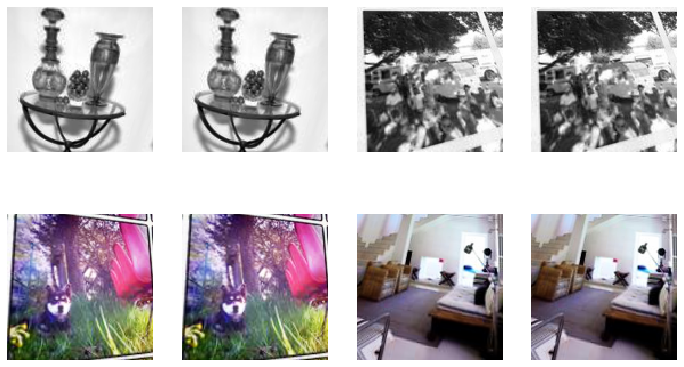

In [5]:
dls = dblock.dataloaders(source, bs=4)
dls.show_batch()

In [6]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [7]:
m = TransformerNet()
learn = style_learner(dls, m, get_feats, style_fns)

(0.0009120108559727668, 0.0003981071640737355)

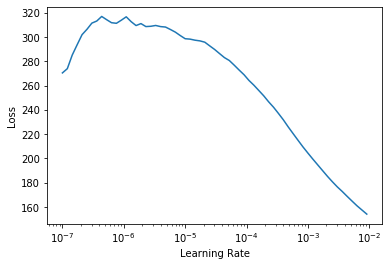

In [8]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,46.242077,23.080196,5.313260,17.266785,0.500153,00:09


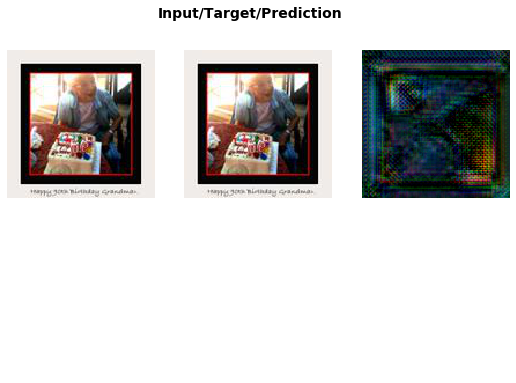

In [15]:
learn.show_results(max_n=1)